# Import statements 

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from  my_ml_lib import MetricTools, PlotTools

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure 
import json
import datetime
import copy
from PIL import Image as im
import joblib
from sklearn.model_selection import train_test_split
# import math as Math
import random
import torch.optim

In [5]:
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision

In [6]:
import cv2

# Saving and Loading code 

In [7]:
# Saving and Loading models using joblib 
def save(filename, obj):
  with open(filename, 'wb') as handle:
      joblib.dump(obj, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load(filename):
  with open(filename, 'rb') as handle:
      return joblib.load(filename)


# Importing Dataset 

In [8]:
data_path = "/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/dataset/train.pkl"
x = load(data_path)

In [9]:
# save_path = "/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/dataset/"
# # saving the images and labels array 
# save(save_path + "data_image.pkl",data_image)
# save(save_path + "data_label.pkl",data_label)
# # dict values where labels key and image arrays as vlaues in form of list 
# save(save_path + "my_dict.pkl",my_dict)

In [10]:
save_path = "/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/dataset/"
# saving the images and labels array 
data_image = load(save_path + "data_image.pkl")
data_label = load(save_path + "data_label.pkl")
# dict values where labels key and image arrays as vlaues in form of list 
my_dict = load(save_path + "my_dict.pkl")

In [11]:
len(data_image) , len(data_label), my_dict.keys()

(5000, 5000, dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))

# Data Class and Data Loaders and Data transforms 

In [12]:
len(x['names']) ,x['names'][4999] , data_image[0].shape

(5000, 'train05000', (32, 32, 3))

## Splitting the data into train and val

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data_image, data_label, test_size=0.10, random_state=42,stratify=data_label )

In [14]:
len(X_train) , len(y_train) , len(X_test) ,len(y_test)

(4500, 4500, 500, 500)

In [15]:
pd.DataFrame(y_test).value_counts() 

9    50
8    50
7    50
6    50
5    50
4    50
3    50
2    50
1    50
0    50
dtype: int64

## Data Class

In [16]:
class myDataClass(Dataset):
  """Custom dataset class"""

  def __init__(self, images, labels , transform=None):

    """
    Args:
        images : Array of all the images 
        labels : Correspoing labels of all the images 
    """
    
    self.images = images
    self.labels = labels
    self.transform = transform
    
  def __len__(self):

    return len(self.images)

  def __getitem__(self, idx):
    # converts image value between 0 and 1 and returns a tensor C,H,W 
    img = torchvision.transforms.functional.to_tensor(self.images[idx])
    target = self.labels[idx]
    

    if self.transform:
        img = self.transform(img)
    return img,target 

## Data Loaders 

In [17]:
batch = 64
train_dataset = myDataClass(X_train, y_train)
test_dataset = myDataClass(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size= batch, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size= batch, shuffle=True)

In [18]:
# next(iter(train_dataloader))[0].shape

In [19]:
len(train_dataloader) , len(test_dataloader)

(71, 8)

# Train and Test functions 

In [20]:
def load_best(all_models,model_test):
  FILE  = all_models[-1]
  
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model_test.parameters(), lr=0)

  checkpoint = torch.load(FILE)
  model_test.load_state_dict(checkpoint['model_state'])
  optimizer.load_state_dict(checkpoint['optim_state'])
  epoch = checkpoint['epoch']
  model_test.eval()

  return model_test


In [21]:
def train(save_path,epochs,train_dataloader,model,test_dataloader,optimizer,criterion,basic_name):
  model_no = 1
  c = 1
  all_models = []

  valid_loss_min = np.Inf 
  train_losses = []
  val_losses = []

  for e in range(epochs):

      train_loss = 0.0
      valid_loss = 0.0

      model.train()
      
      for idx, (images,labels) in enumerate(train_dataloader):
        
          images, labels = images.to(device) , labels.to(device) 
    
          optimizer.zero_grad()        
          log_ps= model(images)
          loss = criterion(log_ps, labels)
          loss.backward()
          optimizer.step()
          
          train_loss += ((1 / (idx + 1)) * (loss.data - train_loss))
      else:

          accuracy = 0
          correct = 0
          model.eval()

          with torch.no_grad():
              for idx, (images,labels) in enumerate(test_dataloader):

                  images, labels = images.to(device) , labels.to(device)

                  log_ps = model(images)
                  
                  _, predicted = torch.max(log_ps.data, 1)
                  loss = criterion(log_ps, labels)

                  # correct += (predicted == labels).sum().item()
                  equals = predicted == labels.view(*predicted.shape)
                  accuracy += torch.mean(equals.type(torch.FloatTensor))
                  valid_loss += ((1 / (idx + 1)) * (loss.data - valid_loss))

          print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
              e+1, 
              train_loss,
              valid_loss
              ), "Test Accuracy: {:.3f}".format(accuracy/len(test_dataloader)))

          train_losses.append(train_loss)
          val_losses.append(valid_loss)

          if valid_loss < valid_loss_min:
            
            print('Saving model..' + str(model_no))
            valid_loss_min = valid_loss

            checkpoint = {
            "epoch": e+1,
            "model_state": model.state_dict(),
            "optim_state": optimizer.state_dict(),
            "train_losses": train_losses,
            "test_losses": val_losses,
            }

            FILE =  save_path + basic_name +"_epoch_" + str(e+1) + "_model_" +  str(model_no)
            all_models.append(FILE)
            torch.save(checkpoint, FILE)
            model_no = model_no + 1
          
  
  save(save_path + basic_name + "_all_models.pkl", all_models)
  return model, train_losses, val_losses, all_models 
   

In [22]:
def plot(train_losses,val_losses,title='Training Validation Loss with CNN'):
  plt.plot(train_losses, label='Training loss')
  plt.plot(val_losses, label='Validation loss')
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  plt.legend()
  _ = plt.ylim()
  plt.title(title)
  # plt.savefig('plots/Training Validation Loss with CNN from scratch.png')
  plt.show()

In [23]:
def test(loader, model, criterion, device, name):
    test_loss = 0.
    correct = 0.
    total = 0.
    y = None
    y_hat = None
    
    model.eval()
    for batch_idx, (images, labels) in enumerate(loader):

        # move to GPU or CPU
        images, labels = images.to(device)   , labels.to(device) 
        target = labels

        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images)
        # calculate the loss
        loss = criterion(output,labels)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]

        if y is None:
            y = target.cpu().numpy()
            y_hat = pred.data.cpu().view_as(target).numpy()
        else:
            y = np.append(y, target.cpu().numpy())
            y_hat = np.append(y_hat, pred.data.cpu().view_as(target).numpy())


        correct += np.sum(pred.view_as(labels).cpu().numpy() == labels.cpu().numpy())
        total = total + images.size(0)
        # if batch_idx % 20 == 0:
        #     print("done till batch" , batch_idx+1)
            
    print(name + ' Loss: {:.6f}\n'.format(test_loss))

    print(name + ' Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))
    return y, y_hat

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [25]:
# def train(save_path,epochs,train_dataloader,model,test_dataloader,optimizer,criterion,basic_name)
# def plot(train_losses,val_losses,title='Training Validation Loss with CNN')
# def test(loader, model, criterion, device)

# Relu [ X=2 Y=3 Z=1 ] and Dropout 

## CNN - Block-1 

### model 

In [26]:
cfg1 = {
    'B1': [16,16,'M','D'],
}

In [27]:
def make_layers1(cfg, batch_norm=True):

    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=4, stride=3)]
        elif v == 'M1':
            layers += [nn.MaxPool2d(kernel_size=2, stride=(1,2),padding=(0,1))]
        elif v == 'D':
            layers += [nn.Dropout(p=0.7)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v

    return nn.Sequential(*layers)

In [28]:
class Model_B1(nn.Module):

    def __init__(self, features):

        super(Model_B1, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Linear(1600, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 64),
            nn.ReLU(True),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        x = self.features(x)
        # print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [29]:
# m = Model_B1(make_layers1(cfg1['B1']))
# for i,l in train_dataloader:
#   o = m(i)

In [30]:
model1 = Model_B1(make_layers1(cfg1['B1'])).to(device) 
learning_rate = 0.01
criterion1 = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=learning_rate)
print(model1)

Model_B1(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=4, stride=3, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.7, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=1600, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=64, bias=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=64, out_features=10, bias=True)
  )
)


###train

In [31]:
# !rm  '/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_3/bw_blocks/Dropout(0.7)/cnn_block1/'*
# !ls  '/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_3/bw_blocks/Dropout(0.7)/cnn_block1/'

In [32]:
save_path1 = "/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_3/bw_blocks/Dropout(0.7)/cnn_block1/"

In [33]:

# /content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_2/cnn_block123
# /content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_2/cnn_block12
# /content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_2/cnn_block1

m, train_losses, val_losses,m_all_models = train(save_path1,100,train_dataloader,model1,test_dataloader,optimizer1,criterion1,"cnn_b1")

Epoch: 1 	Training Loss: 2.333638 	Validation Loss: 2.428886 Test Accuracy: 0.116
Saving model..1
Epoch: 2 	Training Loss: 1.804402 	Validation Loss: 1.623775 Test Accuracy: 0.414
Saving model..2
Epoch: 3 	Training Loss: 1.568994 	Validation Loss: 1.637706 Test Accuracy: 0.382
Epoch: 4 	Training Loss: 1.461967 	Validation Loss: 1.496233 Test Accuracy: 0.466
Saving model..3
Epoch: 5 	Training Loss: 1.408064 	Validation Loss: 1.388066 Test Accuracy: 0.511
Saving model..4
Epoch: 6 	Training Loss: 1.357155 	Validation Loss: 1.430614 Test Accuracy: 0.486
Epoch: 7 	Training Loss: 1.285781 	Validation Loss: 1.341867 Test Accuracy: 0.548
Saving model..5
Epoch: 8 	Training Loss: 1.260166 	Validation Loss: 1.348554 Test Accuracy: 0.549
Epoch: 9 	Training Loss: 1.210654 	Validation Loss: 1.241994 Test Accuracy: 0.588
Saving model..6
Epoch: 10 	Training Loss: 1.177061 	Validation Loss: 1.159511 Test Accuracy: 0.588
Saving model..7
Epoch: 11 	Training Loss: 1.142339 	Validation Loss: 1.296529 Test 

### Plots and test 

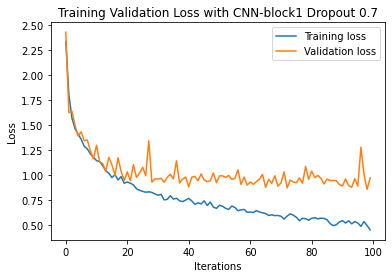

In [34]:
plot(train_losses,val_losses,'Training Validation Loss with CNN-block1 Dropout 0.7')

In [35]:
all_models1 = load(save_path1 + "cnn_b1_all_models.pkl")
FILE  = all_models1[-1]
m = Model_B1(make_layers1(cfg1['B1'])).to(device) 

In [36]:
m = load_best(all_models1,m)

In [37]:
train_y, train_y_hat = test(train_dataloader, m, criterion1, device, "TRAIN")

TRAIN Loss: 0.225281

TRAIN Accuracy: 93% (4219/4500)


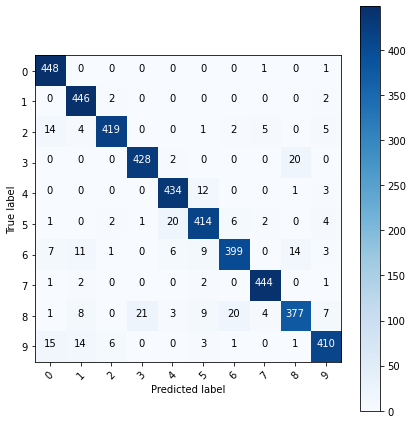

In [38]:
cm = MetricTools.confusion_matrix(train_y, train_y_hat, nclasses=10)
PlotTools.confusion_matrix(cm, [i for i in range(10)], title='',
                           filename='Confusion Matrix with CNN', figsize=(6,6))

In [39]:
test_y, test_y_hat = test(test_dataloader, m, criterion1, device,"TEST")

TEST Loss: 0.854796

TEST Accuracy: 71% (359/500)


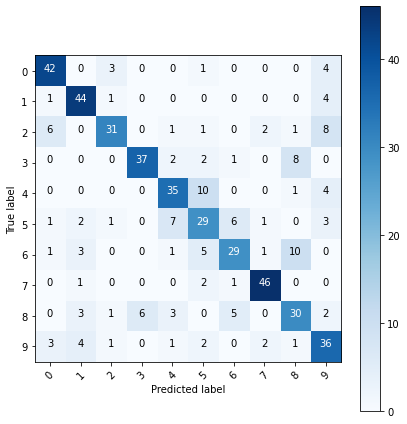

In [40]:
cm = MetricTools.confusion_matrix(test_y, test_y_hat, nclasses=10)
PlotTools.confusion_matrix(cm, [i for i in range(10)], title='',
                           filename='Confusion Matrix with CNN', figsize=(6,6))

## CNN-Block12

### model 

In [41]:
cfg2 = {
    'B12': [16,16,'M','D', 32, 32, 32,'M','D'],
}

In [42]:
def make_layers2(cfg, batch_norm=True):

    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        elif v == 'M1':
            layers += [nn.MaxPool2d(kernel_size=2, stride=1,padding=1)]
        elif v == 'D':
            layers += [nn.Dropout(p=0.7)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v

    return nn.Sequential(*layers)

In [43]:
class Model_B12(nn.Module):
    '''
        Model
    '''
    def __init__(self, features):

        super(Model_B12, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            # nn.Linear(3200, 512),
            # nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 64),
            nn.ReLU(True),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        x = self.features(x)
        # print(x.shape)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [44]:
# m = Model_B12(make_layers2(cfg2['B12']))
# for i,l in train_dataloader:
#   o = m(i)

In [45]:
model2 = Model_B12(make_layers2(cfg2['B12'])).to(device) 
learning_rate = 0.01
criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=learning_rate)
print(model2)

Model_B12(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.7, inplace=False)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (12): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (15): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_run

### Train 

In [46]:
# !rm  '/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_3/bw_blocks/Dropout(0.7)/cnn_block12/'*
# !ls  '/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_3/bw_blocks/Dropout(0.7)/cnn_block12/'

In [47]:
save_path2 = "/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_3/bw_blocks/Dropout(0.7)/cnn_block12/"

In [48]:
m, train_losses, val_losses,m_all_models = train(save_path2,100,train_dataloader,model2,test_dataloader,optimizer2,criterion2,"cnn_b12")

Epoch: 1 	Training Loss: 2.043709 	Validation Loss: 2.526630 Test Accuracy: 0.207
Saving model..1
Epoch: 2 	Training Loss: 1.821620 	Validation Loss: 1.675223 Test Accuracy: 0.368
Saving model..2
Epoch: 3 	Training Loss: 1.732086 	Validation Loss: 1.631676 Test Accuracy: 0.404
Saving model..3
Epoch: 4 	Training Loss: 1.647368 	Validation Loss: 1.594951 Test Accuracy: 0.421
Saving model..4
Epoch: 5 	Training Loss: 1.576912 	Validation Loss: 1.560440 Test Accuracy: 0.463
Saving model..5
Epoch: 6 	Training Loss: 1.536996 	Validation Loss: 1.696865 Test Accuracy: 0.407
Epoch: 7 	Training Loss: 1.484622 	Validation Loss: 1.512875 Test Accuracy: 0.471
Saving model..6
Epoch: 8 	Training Loss: 1.497207 	Validation Loss: 1.501880 Test Accuracy: 0.492
Saving model..7
Epoch: 9 	Training Loss: 1.464367 	Validation Loss: 1.389994 Test Accuracy: 0.493
Saving model..8
Epoch: 10 	Training Loss: 1.402854 	Validation Loss: 1.266547 Test Accuracy: 0.585
Saving model..9
Epoch: 11 	Training Loss: 1.357757 

### Test and Plots 

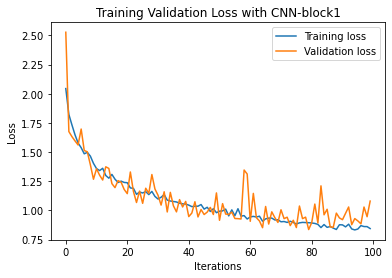

In [49]:
plot(train_losses,val_losses,'Training Validation Loss with CNN-block1')

In [50]:
all_models2 = load(save_path2 + "cnn_b12_all_models.pkl")
FILE  = all_models2[-1]
m2 = Model_B12(make_layers2(cfg2['B12'])).to(device) 

In [51]:
m2 = load_best(all_models2,m2)

In [52]:
train_y, train_y_hat = test(train_dataloader, m2, criterion2, device, "TRAIN")

TRAIN Loss: 0.610383

TRAIN Accuracy: 79% (3572/4500)


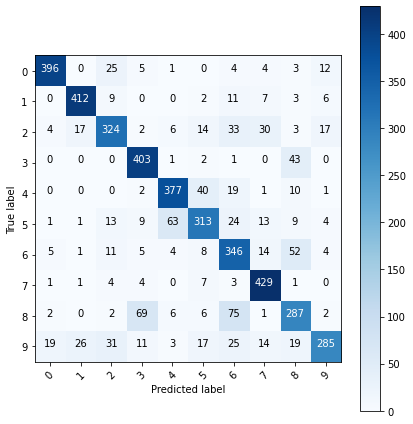

In [53]:
cm = MetricTools.confusion_matrix(train_y, train_y_hat, nclasses=10)
PlotTools.confusion_matrix(cm, [i for i in range(10)], title='',
                           filename='Confusion Matrix with CNN', figsize=(6,6))

In [54]:
test_y, test_y_hat = test(test_dataloader, m2, criterion2, device,"TEST")

TEST Loss: 0.840140

TEST Accuracy: 72% (361/500)


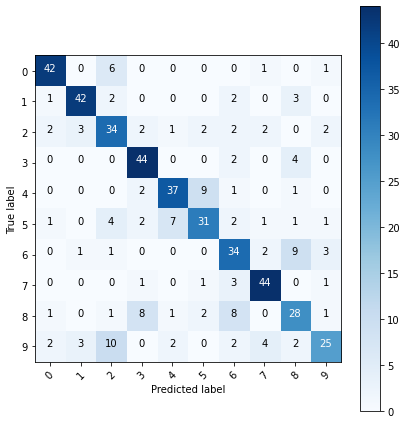

In [55]:
cm = MetricTools.confusion_matrix(test_y, test_y_hat, nclasses=10)
PlotTools.confusion_matrix(cm, [i for i in range(10)], title='',
                           filename='Confusion Matrix with CNN', figsize=(6,6))

## CNN-Block-123

### model 

In [56]:
cfg3 = {
    'B123': [16,16,'M','D',32,32,32,'M','D',64,'M','D'],
}

In [57]:
def make_layers3(cfg, batch_norm=True):

    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        elif v == 'M1':
            layers += [nn.MaxPool2d(kernel_size=2, stride=1)]
        elif v == 'D':
            layers += [nn.Dropout(p=0.7)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v

    return nn.Sequential(*layers)

In [58]:
class Model_B123(nn.Module):
    '''
        Model
    '''
    def __init__(self, features):

        super(Model_B123, self).__init__()
        self.features = features 

        self.classifier = nn.Sequential(
            # nn.Linear(1024, 512),
            # nn.ReLU(True),
            # nn.Linear(512, 256),
            # nn.ReLU(True),
            # nn.Linear(256, 64),
            # nn.ReLU(True),
            nn.Linear(64, 10),
        )
       
    def forward(self, x):
        x = self.features(x)
        # print(x.shape)
        x = x.view(x.size(0), -1)
        
        x = self.classifier(x)
        return x

In [59]:
# m = Model_B123(make_layers3(cfg3['B123']))
# for i,l in train_dataloader:
#   o = m(i)

In [60]:
model3 = Model_B123(make_layers3(cfg3['B123'])).to(device) 
learning_rate = 0.01
criterion3 = nn.CrossEntropyLoss()
optimizer3 = optim.Adam(model3.parameters(), lr=learning_rate)
print(model3)

Model_B123(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.7, inplace=False)
    (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (12): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (15): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_ru

### train 

In [61]:
# !rm  '/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_3/bw_blocks/Dropout(0.7)/cnn_block123/'*
# !ls  '/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_3/bw_blocks/Dropout(0.7)/cnn_block123/'

In [62]:
save_path3 = "/content/drive/MyDrive/SEM-2/05-DL /Assignments/A3/models_saved_Q1/1_3/bw_blocks/Dropout(0.7)/cnn_block123/"

In [63]:
m, train_losses, val_losses,m_all_models = train(save_path3,100,train_dataloader,model3,test_dataloader,optimizer3,criterion3,"cnn_b123")

Epoch: 1 	Training Loss: 2.133285 	Validation Loss: 1.912464 Test Accuracy: 0.310
Saving model..1
Epoch: 2 	Training Loss: 1.891538 	Validation Loss: 1.877542 Test Accuracy: 0.344
Saving model..2
Epoch: 3 	Training Loss: 1.836103 	Validation Loss: 1.854338 Test Accuracy: 0.322
Saving model..3
Epoch: 4 	Training Loss: 1.800500 	Validation Loss: 1.821423 Test Accuracy: 0.298
Saving model..4
Epoch: 5 	Training Loss: 1.782379 	Validation Loss: 1.795855 Test Accuracy: 0.323
Saving model..5
Epoch: 6 	Training Loss: 1.738626 	Validation Loss: 1.737574 Test Accuracy: 0.349
Saving model..6
Epoch: 7 	Training Loss: 1.705035 	Validation Loss: 1.828746 Test Accuracy: 0.324
Epoch: 8 	Training Loss: 1.672993 	Validation Loss: 1.736910 Test Accuracy: 0.368
Saving model..7
Epoch: 9 	Training Loss: 1.660049 	Validation Loss: 1.798230 Test Accuracy: 0.368
Epoch: 10 	Training Loss: 1.626245 	Validation Loss: 1.793805 Test Accuracy: 0.325
Epoch: 11 	Training Loss: 1.600206 	Validation Loss: 1.573492 Test 

### Tests and Plots 

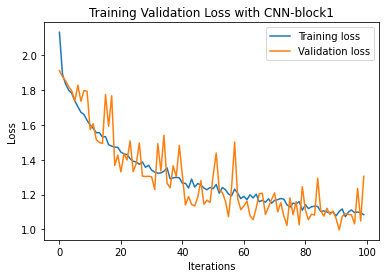

In [64]:
plot(train_losses,val_losses,'Training Validation Loss with CNN-block1')

In [65]:
all_models3 = load(save_path3 + "cnn_b123_all_models.pkl")
FILE  = all_models3[-1]
m3 = Model_B123(make_layers3(cfg3['B123'])).to(device) 

In [66]:
m3 = load_best(all_models3,m3)

In [67]:
train_y, train_y_hat = test(train_dataloader, m3, criterion3, device, "TRAIN")

TRAIN Loss: 0.834854

TRAIN Accuracy: 71% (3198/4500)


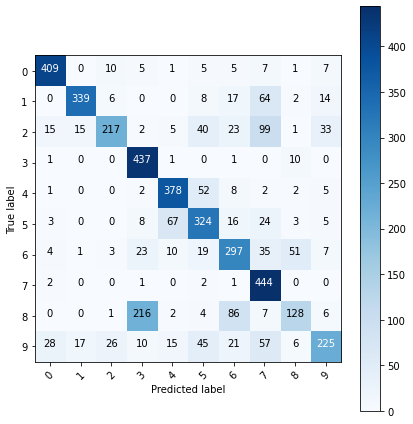

In [68]:
cm = MetricTools.confusion_matrix(train_y, train_y_hat, nclasses=10)
PlotTools.confusion_matrix(cm, [i for i in range(10)], title='',
                           filename='Confusion Matrix with CNN', figsize=(6,6))

In [69]:
test_y, test_y_hat = test(test_dataloader, m3, criterion3, device,"TEST")

TEST Loss: 0.997905

TEST Accuracy: 64% (321/500)


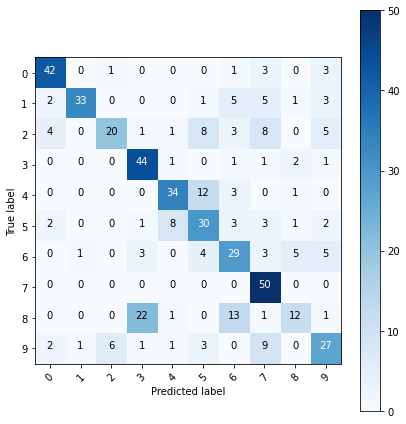

In [70]:
cm = MetricTools.confusion_matrix(test_y, test_y_hat, nclasses=10)
PlotTools.confusion_matrix(cm, [i for i in range(10)], title='',
                           filename='Confusion Matrix with CNN', figsize=(6,6))